In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

In [68]:
#reading the data
df = pd.read_csv("BrentOilPrices.csv", parse_dates=True, index_col=0)


In [69]:
df.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [70]:
df.shape

(8216, 1)

In [71]:
#lets check the null values
df.isnull().sum()


Price    0
dtype: int64

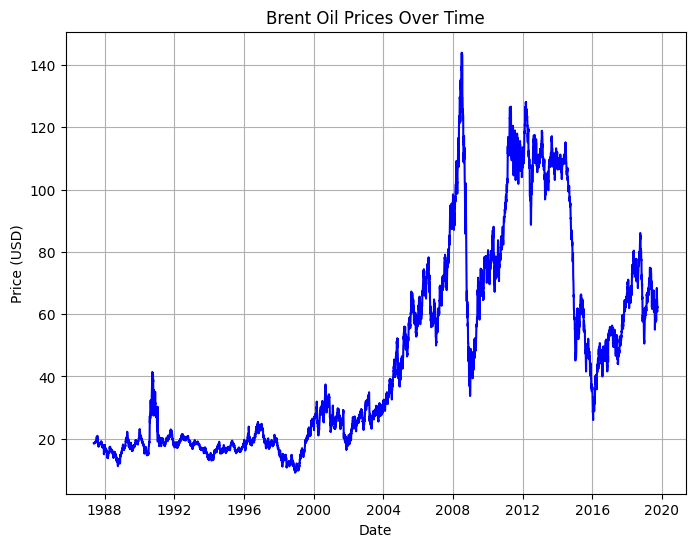

In [72]:
#lets plo the time series data first to have a better understanding
plt.figure(figsize=(8, 6))
plt.plot(df.index, df['Price'], color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


In [73]:
#lets create laggeed features first
df['Price_Lag1'] = df['Price'].shift(1)  #lagged price
df['Price_Lag7'] = df['Price'].shift(7)  #lagged price with a week shift
df['Price_Lag30'] = df['Price'].shift(30)  #lagged price with a month shift

In [74]:
#lets calculate moving averages 
df['3day_MA'] = df['Price'].rolling(window=3).mean()
df['9day_MA'] = df['Price'].rolling(window=9).mean()

In [75]:
df.dropna(inplace=True)

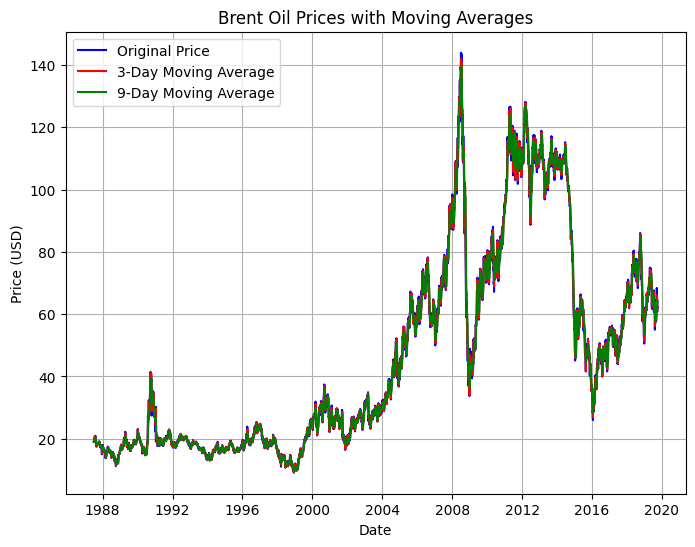

In [76]:
#Lets visualise the moving averages
plt.figure(figsize=(8, 6))
plt.plot(df.index, df['Price'], color='blue', label='Original Price')
plt.plot(df.index, df['3day_MA'], color='red', label='3-Day Moving Average')
plt.plot(df.index, df['9day_MA'], color='green', label='9-Day Moving Average')
plt.title('Brent Oil Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
#as price is our target variable to lets drop it first and keeping the training var in X
X = df.drop('Price', axis=1)
y = df['Price']

X

,Price_Lag1,Price_Lag7,Price_Lag30,3day_MA,9day_MA
Date,,,,,
1987-07-02,18.98,18.90,18.63,19.103333,18.998889
1987-07-03,19.25,18.75,18.45,19.186667,19.024444
1987-07-06,19.33,18.70,18.55,19.353333,19.088889
1987-07-07,19.48,19.08,18.60,19.436667,19.172222
1987-07-08,19.50,19.15,18.63,19.486667,19.258889
...,...,...,...,...,...
2019-09-24,64.66,61.25,59.90,64.673333,64.286667
2019-09-25,64.13,68.42,57.86,63.733333,64.470000
2019-09-26,62.41,65.59,57.37,62.873333,64.562222


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [79]:
#lets use different models to see the best performing one
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR()
}


In [80]:
#training and testing all different models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    results[name] = {'Train R^2': train_r2, 'Test R^2': test_r2, 'Train MSE': train_mse, 'Test MSE': test_mse}

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e+03, tolerance: 6.625e+02
  model = cd_fast.enet_coordinate_descent(


In [81]:
#lets make a dataframe of the results so later on we can plot it
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Model Evaluation Results:\n", results_df)

Model Evaluation Results:
                            Train R^2  Test R^2  Train MSE  Test MSE
Linear Regression           0.999561  0.999577   0.473503  0.441959
Ridge Regression            0.999561  0.999577   0.473504  0.441910
Lasso Regression            0.999093  0.999178   0.978370  0.859305
Random Forest               0.999901  0.999352   0.106616  0.676986
Gradient Boosting           0.999506  0.999324   0.532704  0.706724
Support Vector Regression   0.998238  0.998557   1.900973  1.507567


In [82]:
best_model_name = results_df['Test R^2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

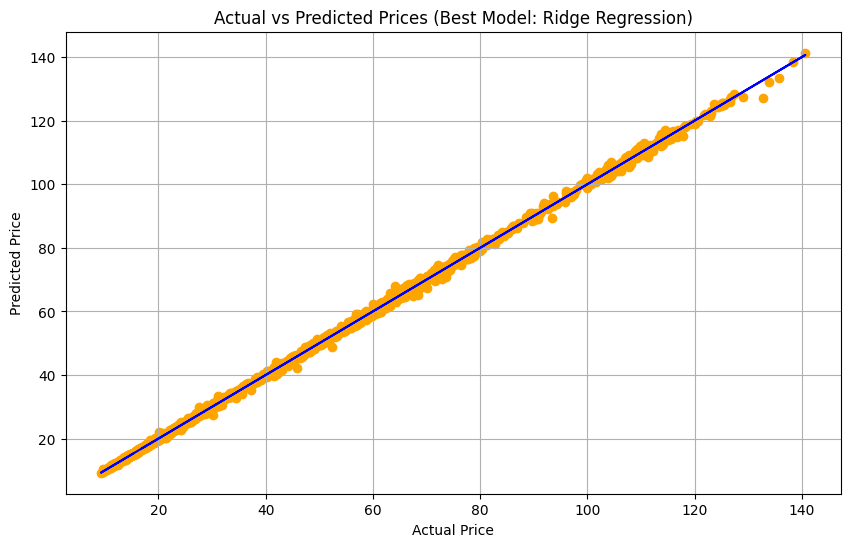

In [83]:
#Lets plot the actial vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, color='orange')
plt.plot(y_test, y_test, color='blue')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Best Model: {})'.format(best_model_name))
plt.grid(True)
plt.show()